In [10]:
# !pip install -e ~/Code/xmip

# Working with output from many different CMIP6 climate models

Climate modeling has been a cornerstone of understanding our climate and the [consequences of continued emissions of greenhouse gases](https://www.gfdl.noaa.gov/awards/former-noaa-scientist-suki-manabe-shares-nobel-prize-in-physics-for-pioneering-climate-prediction/) for decades. Much of the recent efforts in the community have been focus on model intercomparison projects (MIPs), which invite submissions of many different modeling groups around the world to run their models (which are all set up slightly different) under centralized forcing scenarios. These results can then be analyzed and the spread between different models can give an idea about the certainty of these predictions. The recent [Coupled Model Intercomparison Project Phase 6](https://gmd.copernicus.org/articles/9/1937/2016/) (CMIP6) represents an international effort to represent the state-of-the-art knowledge about how the climate system might evolve in the future and informs much of the [Intergovernmental Panel on Climate Change Report]([Intergovernmental Panel on Climate Change Report](https://github.com/IPCC-WG1/Chapter-9).

In this lecture we will learn how to quickly search and analyze CMIP6 data with Pangeo tools in the cloud, a process that using the 'download and analyze' workflow often becomes prohibitively slow and inefficient due to the sheer scale of the data.

The basis for this workflow are the analysis-ready-cloud-optimized repositories of CMIP6 data, which are currently maintained by the pangeo community and publicly available on both [Google Cloud Storage](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396) and [Amazon S3](https://www.youtube.com/watch?v=C0UhiiGgbWA&t=3267s) as a collection of [zarr](https://zarr.readthedocs.io/en/stable/) stores.

The cloud native approach enables scientific results to be fully reproducible, encouraging to build onto and collaborate on scientific results.  

In [36]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt


The first thing we have to do is to get an overview of all the data available. In this case we are using [intake-esm](https://intake-esm.readthedocs.io/en/stable/index.html) to load a collection of zarr stores on Google Cloud Storage, but there are [other options](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html) to access the data too.

Lets create a collection object and look at it


In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


This object describes all the available data (over 500k single zarr stores!). The rows describe different 'facets' that can be used to search and query subsets of the data. For detailed info on each of the facets please refer to this [document](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit).

So obviously we never want to work with *all* the data. Lets check out how to get a subset.

In [3]:
# create a smaller catalog from the full collection using faceted search
cat = col.search(
    variable_id='tas', # atmospheric surface temperature
    experiment_id='historical', # only runs for the historical forcing period
    table_id='Amon', # monthly atmospheric data
    source_id=['IPSL-CM6A-LR', 'MRI-ESM2-0', 'GFDL-ESM4'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'],
    )
# read all datasets into a dictionary but apply the xmip preprocessing before
ddict = cat.to_dataset_dict(preprocess=combined_preprocessing, xarray_open_kwargs={'use_cftime':True}) 



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is a

Here we did two things: 
- We searched the full collection based on a combination of facets like the variable, the experiment and only a test set of models.
- We loaded the datasets into a dictionary of xarray datasets (note they are not loaded into memory, but instead these are lazyly loaded dask arrays -- more on this in the following lectures).

In [27]:
list(ddict.keys())

['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn']

You can see that we have three different models. Lets look at them in a bit more detail to understand the layout:

In [28]:
ddict['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

<xarray.Dataset>
Dimensions:         (member_id: 5, dcpp_init_year: 1, time: 1980, y: 143,
                     x: 144, bnds: 2)
Coordinates:
    height          float64 2.0
  * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
    lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * member_id       (member_id) object 'r1i1p1f1' 'r2i1p1f1' ... 'r5i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 143, 144), meta=np.ndarray>
Attributes: (12/53)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    variant_info:                     Restart from another point in piControl...
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr

In [29]:
ddict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1']

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 180,
                     x: 288, bnds: 2, vertex: 4)
Coordinates: (12/13)
    height          float64 2.0
  * y               (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds      (y, bnds, x) float64 dask.array<chunksize=(180, 2, 288), meta=np.ndarray>
  * x               (x) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bounds      (x, bnds, y) float64 dask.array<chunksize=(288, 2, 180), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    ...              ...
    lon             (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat             (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds, vertex
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 429, 180, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amo...

You can see that both datasets have the same names for many of the coordinates (e.g. 'x' and 'y' for the logical indices in zonal and meridional direction). This is actually not quite the case for the raw CMIP6 data, which is why [xMIP](https://github.com/jbusecke/xMIP) was developed in an effort to crowdsource these common data-cleaning tasks. For this example we only use the `combined_preprocessing` function which fixes some of the naming, but check out the [docs](https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest) to see more helpful code for CMIP analysis.

Ok but now lets analyze the data! Using what we know about xarray we can get a timeseries of the global surface temperature:

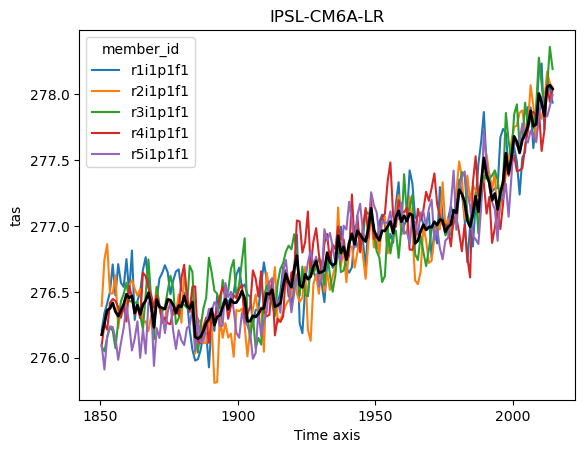

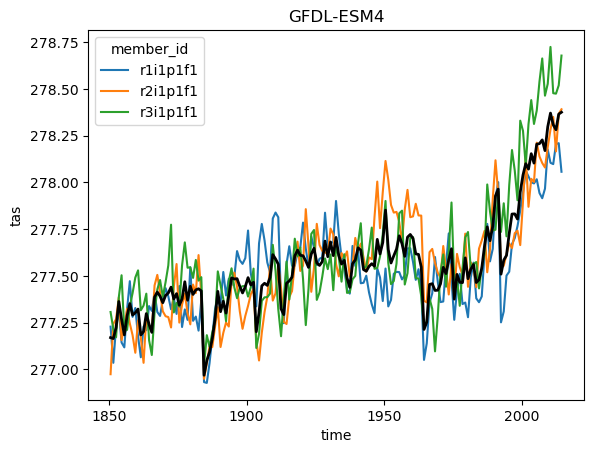

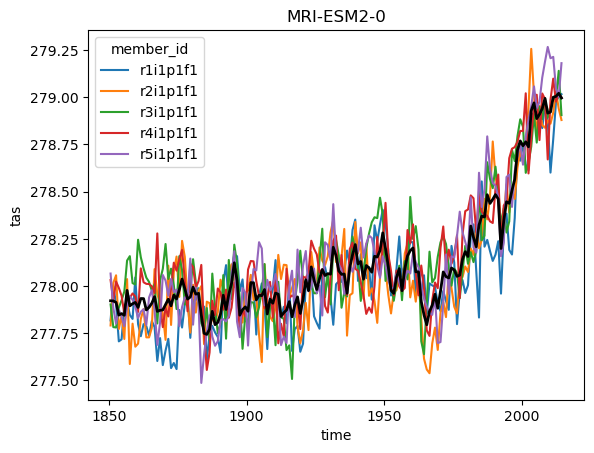

In [30]:

for name, ds in ddict.items():
    # construct yearly global mean timeseries
    mean_temp = ds.tas.mean(['x', 'y']).coarsen(time=12).mean()
    plt.figure()
    mean_temp.plot(hue='member_id')
    # lets also plot the average over all members
    mean_temp.mean('member_id').plot(color='k', linewidth=2)
    plt.title(ds.attrs['source_id']) #Extract the model name right from the dataset metadata


But wait! This is not exactly right. We need to weight the spatial mean by the area of each grid cell, since the area varies based on the position on the globe (and the particularities of the curvilinear grid used in each model). But we can easily query the cell area from the cloud and match them to the data using xmip

In [33]:
# Repeat the above steps to get the cell area matching the temperature we loaded earlier
cat_area = col.search(
    variable_id='areacella', # load the atmospheric grid area
    experiment_id='historical', 
    table_id='fx', #
    source_id=['IPSL-CM6A-LR', 'MRI-ESM2-0', 'GFDL-ESM4'], 
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'],
    )
# read all datasets into a dictionary but apply the xmip preprocessing before
ddict_area = cat_area.to_dataset_dict(
    storage_options={'anon':True},
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True}
    ) 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is a

/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/juliusbusecke/miniconda/envs/earth-env-data-science-book/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is a

/Users/juliusbusecke/Code/xMIP/xmip/preprocessing.py:84: UserWarning: rename 'bnds' to 'bnds' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  return obj.rename({kk: vv for kk, vv in rdict.items() if kk in obj.dims})


In [34]:
list(ddict_area.keys())

['CMIP.IPSL.IPSL-CM6A-LR.historical.fx.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.fx.gr1',
 'CMIP.MRI.MRI-ESM2-0.historical.fx.gn']

You can inspect the new dictionary `ddict_area` and will find that the structure is very similar to the one for surface temperature above.

In [37]:
ddict_w_area = match_metrics(ddict, ddict_area, 'areacella', dim_length_conflict='align')

/Users/juliusbusecke/Code/xMIP/xmip/postprocessing.py:83: UserWarning: Match attributes ['variant_label'] not found in any of the datasets.         This can happen when several combination functions are used and attributes are removed during merging.         Double check the results.
  warnings.warn(
/Users/juliusbusecke/Code/xMIP/xmip/postprocessing.py:571: UserWarning: CMIP.NOAA-GFDL.GFDL-ESM4.historical.none.Amon.gr1.none.tas:`metric` dimensions ['member_id:1'] do not match `ds` ['member_id:3']. Aligning the data on `inner`
  warnings.warn(msg + " Aligning the data on `inner`")


In [38]:
ddict_w_area['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1']

<xarray.Dataset>
Dimensions:         (y: 162, x: 257, time: 1980, member_id: 1,
                     dcpp_init_year: 1, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * y               (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x               (x) float64 0.625 3.125 4.375 5.625 ... 356.9 358.1 359.4
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 2.0
    ...              ...
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon             (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat             (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 257, 162), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 257, 162), meta=np.ndarray>
    areacella       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 162, 257), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 429, 162, 257), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amo...

Ok the dataset now has a matching `areacella` coordinate that we can use to weight our results. To see the effect of area weighting we will plot both timeseries (only the member average).

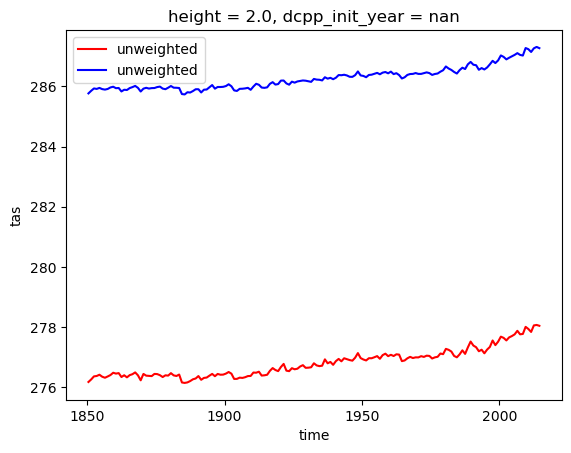

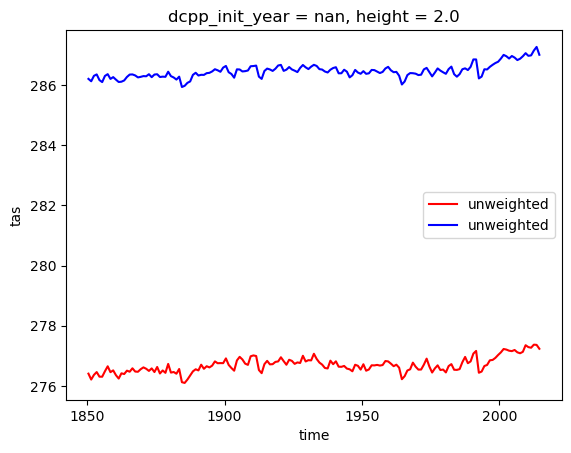

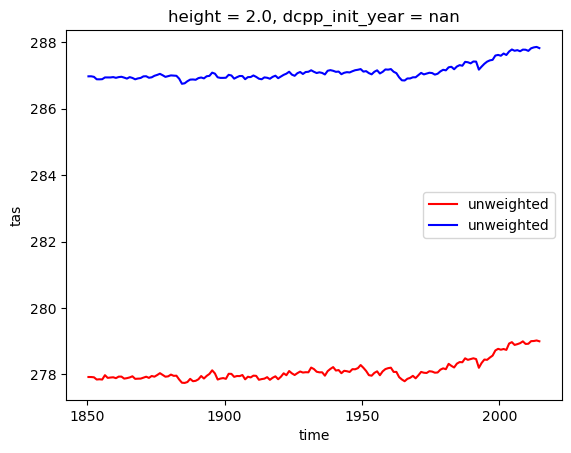

In [39]:
for name, ds in ddict_w_area.items():
    # construct yearly global mean timeseries
    mean_temp = ds['tas'].mean(['x', 'y']).coarsen(time=12).mean()
    mean_temp_weighted = ds['tas'].weighted(ds.areacella).mean(['x', 'y']).coarsen(time=12).mean()
    plt.figure()
    # lets look at the difference
    mean_temp.mean('member_id').plot(label = 'unweighted', color='r')
    mean_temp_weighted.mean('member_id').plot(label = 'weighted', color='b')
    plt.title(ds.attrs['source_id'])
    plt.legend()

Quite the difference! This makes sense when we think about the fact that generally cells near the poles become smaller, and if we do a naive mean, these will count too strongly into the global value and reduce the resulting temperature.

Ok lets finish by making a single nice plot of all models. In order to compare the models better we will look at the anomaly of temperature with regard to the period of 1850-1900.

Text(0.5, 1.0, 'Global average surface temperature')

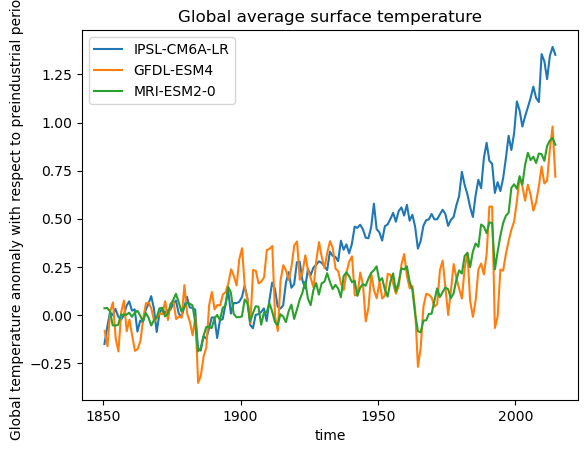

In [43]:
plt.figure()
timeseries_dict = {}
for name, ds in ddict_w_area.items():
    # construct yearly global mean timeseries
    mean_temp_weighted = ds['tas'].weighted(ds.areacella).mean(['x', 'y']).coarsen(time=12).mean()
    anomaly = mean_temp_weighted - mean_temp_weighted.sel(time=slice('1850', '1900')).mean('time')
    anomaly.mean('member_id').plot(label = ds.attrs['source_id'])
plt.legend()
plt.ylabel('Global temperature anomaly with respect to preindustrial period')
plt.title('Global average surface temperature')